This notebook discusses:

- Vanishing and Exploding Gradients
- Transfer Learning and unsupervised pretraining
- Various optimizer techniques to speed up training
- Regularization Techniques 

### Vanishing/Exploding Gradients
Generally, DNNs suffer from unstable gradiens and learn at different speeds. As the layer gets deeper and deeper the Gradient Descent update during backpropagation leaves the lower connection weights unchanged, this is called Gradient vanishing. However, in some cases, the gradient could grow bigger! - this is called Exploding Gradients but this is typical for Recurrent Neural Networks. 
This problem is commonly found in the Sigmoid Activation Function

(-5.0, 5.0, -0.1, 1.1)

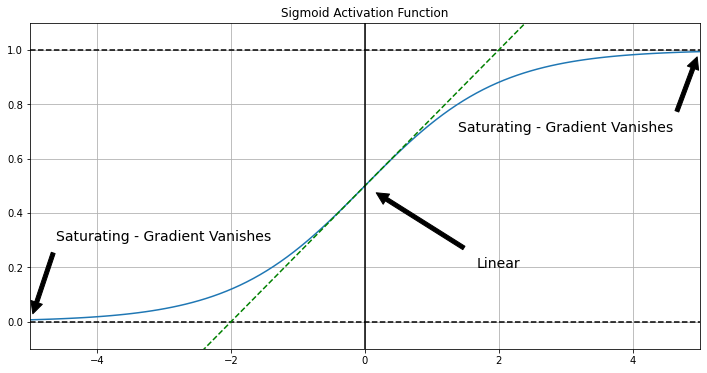

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 100)
plt.figure(figsize= (12, 6))
plt.plot(z, sigmoid(z))

#asymptotes
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([-5, 5], [1, 1], 'k--')

plt.plot([-5, 5], [-3/4, 7/4], 'g--')

#centr line
plt.plot([0, 0], [-2, 2], 'k-')

#annotate
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating - Gradient Vanishes', xytext=(3, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating - Gradient Vanishes', xytext=(-3, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")


plt.grid('on')
plt.title('Sigmoid Activation Function')
plt.axis([-5, 5, -0.1, 1.1])

 #### During backpropagation we need gradient to have equal variance across the layers in both directions. 
 By having this, the signal from each layer can flow properly throughout the network backwards and forwards. 
 
 Fortunetly, there are many methods that help us achieve this but we need to use them with the correct initializer. An initializier sets the values of the weights randomly. If you set all the weights to the same value it will converge as if it contained just 1 neuron per layer. All the bias terms can be set to 0 and the network will work fine and may switch on the bias term is required.  
 
Initialization Method; Activation Function; Variance (Normal)

Glorat - None, Tanh, Logistic, Softmax - 1/fan$_{avg}$

He - ReLU Variants - 2/fan$_{in}$

LeCun - SELU - 1/fan$_{in}$

The default for keras is Glorat initialization with uniform distribution but if you need to change it then you need to set the initializer. 

In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
[i for i in dir(keras.initializers) if not i.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [3]:
# Setting He Initialization, with Kernel_initializer set to normal
keras.layers.Dense(10, activation= 'relu', kernel_initializer= 'he_normal')

In [4]:
# Setting He Initialization, with Kernel_initializer set to uniform you ave to use variance scaling

#you can scale the initializer with a different fan instead of fan_in, you can set it fan_avg instead 
init = keras.initializers.VarianceScaling(scale=2., mode= 'fan_avg', distribution= 'uniform')
keras.layers.Dense(10, activation= 'relu', kernel_initializer= init)

### The ReLU activation function is linear for positive values but 0 all the time for negative values. This saturation causes a problem 
Imagine a neuron, where all the weighted sum inputs always add up to a negative number regardless of the input. This neuron is effectively dead becase it is not outputting anything but 0, especially for large learning rates. Gradient descent will not help either, as the gradient will be 0 also for negative values. 

Alas, we have variants of ReLU, where it was found that leaky variants outperform the plain vanilla ReLU. The hyperparameter $\alpha~0.01$ defines how much the function 'leaks', and is the slope of the function when the values are negative. This ensures that neurons never die, all variants play around with the hyperparameteer $\alpha$ or allows non zero gradients for $z$ < 0:
- __Leaky ReLU__ - setting the hyperparameter $\alpha$ to a larger value ~0.2 tends to perform better than the smaller leaks.
- __Randomized ReLU__ - randomly setting the hyperparameter $\alpha$ within a given range during training and fixed to the average value during testing. This helped reduce overfitting and acted as a great regularizer. 
- __Parametric ReLU (PReLU)__ - $\alpha$ is learnt during training where backpropagation modifies this like any other parameter. It performs well on large datasets but not that great on smaller ones, where it starts to overfit the training set. 
- __Exponential Linear Unit (ELU)__ - outperformed all of the above with faster learning and higher classification accuracies. However, slow computation due to the the exponential function, of course.
- __Scaled Exponential Linear Unit (SELU)__ - outperforms all of the above where the neural network consists of <b>dense sequential layers</b> and all hidden layers use the SELU activation function. The function introduces a novel regularization scheme. However, there are a few conditions that all input must be standardized (mean- 0 and $\sigma$=1, kernal_initializer must be set to 'lecun_normal' distribution.

In summary, use SELU (if you can scale and the network architecture permits) otherwise use ELU, if neither work then use Leaky ReLU. If speed your priority, then use simple ReLU as most libraries provide ReLU specific optimizations.

In [5]:
def relu(z):
    return np.maximum(z, 0)

def leaky_relu(z, alpha= 0.01):
    return np.maximum(z*alpha, z)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

(-1.0, 0.2, -0.2, 0.2)

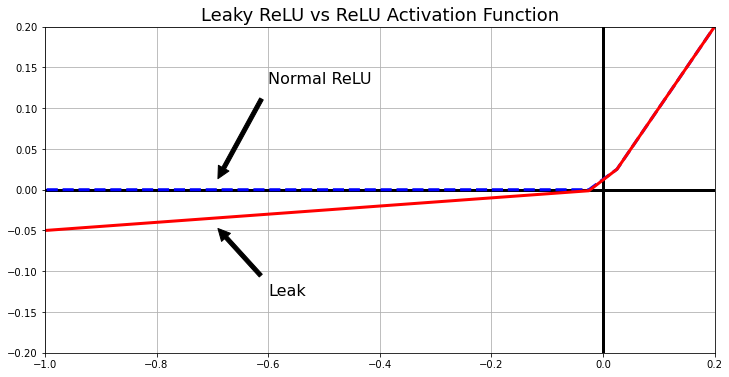

In [6]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize= (12, 6))
plt.plot([-5, 5], [0, 0], 'k-', linewidth=3)
plt.plot([0, 0], [-5, 5], 'k-', linewidth=3)
plt.plot(z, relu(z), 'b--', linewidth=3)
plt.plot(z, leaky_relu(z,0.05), 'r-', linewidth=3)


props = dict(facecolor= 'black', shrink=0.1)
plt.annotate('Leak', xytext=(-0.6, -0.13), fontsize=16, arrowprops= props, xy= (-0.7, -0.04))
plt.annotate('Normal ReLU', xytext=(-0.6, 0.13), fontsize=16, arrowprops= props, xy= (-0.7, 0.001))

plt.title('Leaky ReLU vs ReLU Activation Function', fontsize= 18)
plt.grid('on')
plt.axis([-1, 0.2, -0.2, 0.2])

(-4.0, 4.0, -2.0, 3.0)

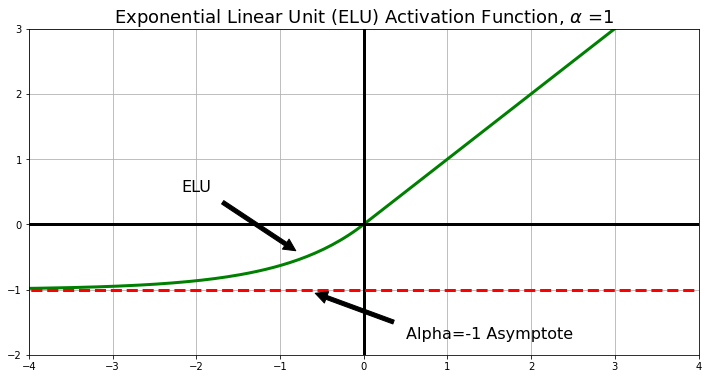

In [7]:
plt.figure(figsize= (12, 6))
plt.plot(z, elu(z,1), 'g-', linewidth=3)
plt.plot([-5, 5], [0, 0], 'k-', linewidth=3)
plt.plot([0, 0], [-5, 5], 'k-', linewidth=3)

plt.plot([-5, 5], [-1, -1], 'r--', linewidth=3)

plt.title('Exponential Linear Unit (ELU) Activation Function, $\\alpha$ =1', fontsize= 18)
plt.annotate('ELU', xytext=(-2, 0.5), fontsize=16, arrowprops= props, xy= (-0.7, -0.5), ha='center')
plt.annotate('Alpha=-1 Asymptote', xytext=(0.5, -1.75), fontsize=16, arrowprops= props, xy= (-0.7, -1), ha='left')

plt.grid('on')
plt.axis([-4, 4, -2, 3])

In [8]:
# Other types of activation functions
[f for f in dir(keras.activations) if not f.startswith('__')]

['_sys',
 'deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [9]:
#Types of ReLU variation layers you can add 
[L for L in dir(keras.layers) if 'relu' in L.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [10]:
# load example data

(X_train_full, y_train_full), (X_test_full, y_test_full) = keras.datasets.fashion_mnist.load_data()

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

X_train_scaled = X_train / 255.0
X_valid_scaled = X_valid / 255.0
X_test_scaled = X_test_full / 255.0

In [11]:
len(X_train)

55000

To use a Leaky ReLU or PReLU, ELU or SELU you need to create a ReLU layer and it will add it to the layer before the one you want to apply it to.
#### Leaky ReLU

In [12]:
# build model
keras.backend.clear_session()
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer= 'he_normal'),
    keras.layers.LeakyReLU(alpha= 0.2), #Leaky ReLU applies this to the layer above
    keras.layers.Dense(100, kernel_initializer= 'he_normal'),
    keras.layers.LeakyReLU(alpha= 0.2),
    keras.layers.Dense(10, activation= 'softmax')
])

In [13]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy, metrics= ['accuracy'],
             optimizer= keras.optimizers.SGD(lr= 0.001))

In [14]:
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size= 1,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
55000/55000 [==============================] - 115s 2ms/step - loss: 0.5548 - accuracy: 0.8060 - val_loss: 0.4677 - val_accuracy: 0.8358
Epoch 2/5
55000/55000 [==============================] - 118s 2ms/step - loss: 0.4140 - accuracy: 0.8536 - val_loss: 0.3845 - val_accuracy: 0.8664
Epoch 3/5
55000/55000 [==============================] - 121s 2ms/step - loss: 0.3755 - accuracy: 0.8644 - val_loss: 0.3618 - val_accuracy: 0.8710
Epoch 4/5
55000/55000 [==============================] - 121s 2ms/step - loss: 0.3496 - accuracy: 0.8745 - val_loss: 0.3834 - val_accuracy: 0.8624
Epoch 5/5
55000/55000 [==============================] - 120s 2ms/step - loss: 0.3326 - accuracy: 0.8793 - val_loss: 0.3423 - val_accuracy: 0.8778


In [15]:
keras.backend.clear_session()

#### Parametric ReLU

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer= 'he_normal'),
    keras.layers.PReLU(), #Leaky ReLU applies this to the layer above
    keras.layers.Dense(100, kernel_initializer= 'he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation= 'softmax')])
    
model.compile(loss= keras.losses.sparse_categorical_crossentropy, metrics= ['accuracy'],
             optimizer= keras.optimizers.SGD(lr= 0.001))

In [17]:
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=1,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
55000/55000 [==============================] - 125s 2ms/step - loss: 0.5623 - accuracy: 0.8062 - val_loss: 0.4462 - val_accuracy: 0.8494
Epoch 2/5
55000/55000 [==============================] - 125s 2ms/step - loss: 0.4166 - accuracy: 0.8507 - val_loss: 0.3891 - val_accuracy: 0.8634
Epoch 3/5
55000/55000 [==============================] - 124s 2ms/step - loss: 0.3734 - accuracy: 0.8654 - val_loss: 0.3473 - val_accuracy: 0.8794
Epoch 4/5
55000/55000 [==============================] - 123s 2ms/step - loss: 0.3453 - accuracy: 0.8759 - val_loss: 0.3365 - val_accuracy: 0.8804
Epoch 5/5
55000/55000 [==============================] - 123s 2ms/step - loss: 0.3262 - accuracy: 0.8818 - val_loss: 0.3247 - val_accuracy: 0.8854


#### Exponential Linear Unit
Same as the above but use set the activation= 'elu' when building a Dense layer, i.e. keras.layers.Dense(10, activation="elu")

In [18]:
#for example: 
# keras.layers.Dense(300, activation="elu")
# keras.layers.Dense(10, activation="elu")

#### Scaled Exponential Linear Unit (SELU)
SELU uses the LeCun initialization and will allow self normalizing. However, you cannot use $\ell_1$ or $\ell_2$ regularization, skip connections other non-Sequential network architectures.

The below code derives $\alpha_{01}$ and $\lambda_{01}$ as defined by the paper - https://arxiv.org/abs/1706.02515
It uses the error function and equation 14 from the paper.
https://en.wikipedia.org/wiki/Error_function

In [19]:
from scipy.special import erfc
alpha01= -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(0.5) - 1)
lambda01 = (1 - erfc(1 / np.sqrt(2)) * (np.e**0.5)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2
+ np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e) + np.pi + 2) ** (-0.5)

print(alpha01, lambda01)
alpha01 * lambda01

1.6732632423543778 1.0507009873554805


1.7580993408473773

In [20]:
def selu(z, scale= lambda01, alpha= alpha01):
    return np.where(z < 0, scale*((alpha*np.exp(z)) - alpha), scale*z)

(-4.0, 4.0, -2.0, 3.0)

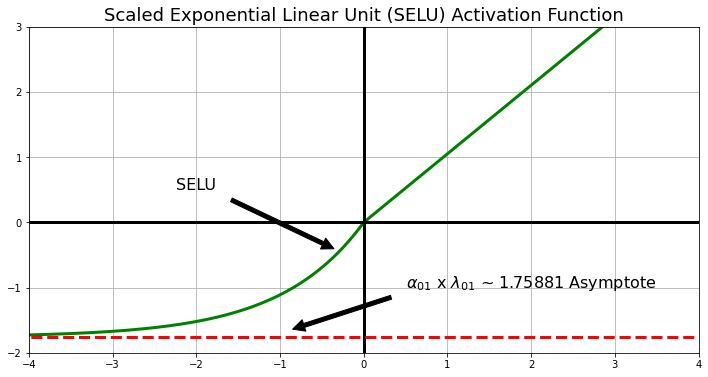

In [21]:

plt.figure(figsize= (12, 6))
plt.plot(z, selu(z), 'g-', linewidth=3)
plt.plot([-5, 5], [0, 0], 'k-', linewidth=3)
plt.plot([0, 0], [-5, 5], 'k-', linewidth=3)

plt.plot([-5, 5], [-1.758, -1.758], 'r--', linewidth=3)

plt.title('Scaled Exponential Linear Unit (SELU) Activation Function', fontsize= 18)
plt.annotate('SELU', xytext=(-2, 0.5), fontsize=16, arrowprops= props, xy= (-0.2, -0.5), ha='center')
plt.annotate('$\\alpha_{01}$ x $\\lambda_{01}$ ~ 1.75881 Asymptote', xytext=(0.5, -1), fontsize=16,
             arrowprops= props, xy= (-1, -1.7), ha='left')

plt.grid('on')
plt.axis([-4, 4, -2, 3])

SELU allows each layer to scale well, giving a mean output of each neuron per layer ~ 0 and standard deviation ~ 1. Avoiding the __exploding and vanishing__ gradients problem.

In [22]:
Z = np.random.normal(size= (100, 100)) #therefore, fan average = 100
for layer in range(1000):
    W = np.random.normal(size= (100, 100), scale= np.sqrt(1/100)) #LeCun initialization = sqrt(1/fan_avg)
    Z = selu(np.dot(Z, W)) #Z_next layer = np.dot(z, W)
    means = np.mean(Z, axis=0).mean()
    sd = np.std(Z, axis=0).mean()
    if layer % 100 ==0:
        print('Layer {}: Mean {:2f}, Standard Deviation {:2f}'.format(layer, means, sd))


Layer 0: Mean -0.021184, Standard Deviation 0.977014
Layer 100: Mean -0.004168, Standard Deviation 0.927482
Layer 200: Mean 0.045456, Standard Deviation 0.929600
Layer 300: Mean 0.035817, Standard Deviation 0.983949
Layer 400: Mean 0.055209, Standard Deviation 0.971585
Layer 500: Mean 0.013397, Standard Deviation 0.956471
Layer 600: Mean -0.007382, Standard Deviation 0.949327
Layer 700: Mean -0.002766, Standard Deviation 0.898141
Layer 800: Mean -0.054391, Standard Deviation 0.881740
Layer 900: Mean -0.005986, Standard Deviation 0.915958


As you can see the mean is approximately ~0  and the Standard Deviation is around 1.

Implementing SELU in a Keras Model, 
is as easy as setting the activation= 'selu', and kernel_initializer= 'lecun_normal'

Concretely, 
__keras.models.layer(300, activation= 'selu', kernel_initializer= 'lecun_normal')__

In [23]:
keras.backend.clear_session()


In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape= [28, 28]))
model.add(keras.layers.Dense(300, activation= 'selu', kernel_initializer= 'lecun_normal'))

#create a 100 deep neural network
for layer in range(99):
    model.add(keras.layers.Dense(100, activation= 'selu', kernel_initializer= 'lecun_normal'))

model.add(keras.layers.Dense(10, activation= 'softmax'))

In [25]:
model.compile(loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'],
              optimizer=keras.optimizers.SGD(lr= 0.001))

Before you train a model, the inputs need to be scaled with mean 0 and standard deviation 1.

In [26]:
#example
a = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
print(a)
a.mean(axis=1)

[[1 2]
 [3 4]
 [5 6]
 [7 8]]


array([1.5, 3.5, 5.5, 7.5])

In [27]:
pixel_means = X_train_scaled.mean(axis=0, keepdims=True)
pixel_std = X_train_scaled.std(axis=0, keepdims=True)
pixel_means.shape #mean across the entire sample

(1, 28, 28)

In [28]:
X_train_scaled = (X_train_scaled - pixel_means) / pixel_std
X_valid_scaled = (X_valid_scaled - pixel_means) / pixel_std
X_test_scaled = (X_test_full - pixel_means) / pixel_std
X_train_scaled.shape
X_train_scaled[10].std()

0.7868150974868058

__Warning__: Keras .fit() method will default to a batch size of 32 if unspecified. This caused a few problems for me, see below.
https://github.com/ageron/handson-ml2/issues/186

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5, batch_size= 1,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
55000/55000 [==============================] - 367s 7ms/step - loss: 2.0679 - accuracy: 0.1735 - val_loss: 2.3472 - val_accuracy: 0.0986
Epoch 2/5
55000/55000 [==============================] - 364s 7ms/step - loss: 2.1081 - accuracy: 0.1809 - val_loss: 1.9232 - val_accuracy: 0.2670
Epoch 3/5
55000/55000 [==============================] - 371s 7ms/step - loss: 1.9119 - accuracy: 0.2710 - val_loss: 1.7759 - val_accuracy: 0.3450
Epoch 4/5
55000/55000 [==============================] - 382s 7ms/step - loss: 1.7824 - accuracy: 0.3212 - val_loss: 1.6775 - val_accuracy: 0.3756
Epoch 5/5
55000/55000 [==============================] - 340s 6ms/step - loss: 1.5983 - accuracy: 0.4065 - val_loss: 1.4544 - val_accuracy: 0.4510


Comparing this with a typical ReLU activation function that causes vanishing and exploding gradients, ruining the accuracy

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape= [28, 28]))
model.add(keras.layers.Dense(300, activation= 'relu', kernel_initializer= 'he_normal'))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation= 'relu', kernel_initializer= 'he_normal'))
model.add(keras.layers.Dense(10, activation= 'softmax'))

In [32]:
model.compile(loss= 'sparse_categorical_crossentropy',optimizer= 'sgd',
             metrics= ['accuracy'])

In [33]:
model.fit(X_train_scaled, y_train, epochs=5, batch_size= 1,
         validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
55000/55000 [==============================] - 349s 6ms/step - loss: 2.3056 - accuracy: 0.1002 - val_loss: 2.3049 - val_accuracy: 0.1008
Epoch 2/5
55000/55000 [==============================] - 391s 7ms/step - loss: 2.3050 - accuracy: 0.0979 - val_loss: 2.3049 - val_accuracy: 0.0976
Epoch 3/5
55000/55000 [==============================] - 396s 7ms/step - loss: 2.3049 - accuracy: 0.1002 - val_loss: 2.3093 - val_accuracy: 0.0914
Epoch 4/5
55000/55000 [==============================] - 391s 7ms/step - loss: 2.3047 - accuracy: 0.1007 - val_loss: 2.3032 - val_accuracy: 0.0986
Epoch 5/5
55000/55000 [==============================] - 389s 7ms/step - loss: 2.3050 - accuracy: 0.0985 - val_loss: 2.3050 - val_accuracy: 0.0986


# Batch Normalization 

Although, He initialization should be used with ReLU and it's variants (including ELU) to reduce vanishing/exploding gradient problems but this does not guarentee that they won't come back during training.

This is where __Batch Normalization__ shines. This includes adding an extra operation between each hidden layers, that scales and shifts the result of each layer (zero centre with std of 1). To calcuate the output of the BN layer, we use the batch algorithm $z^i = XW' + b'$(<i>note: this is a summary of the full algorithm, this equation is used to combine the previous layer's input to the BN, providing a fused version of BN, thus eliminating the need to have a separate layer for BN</i>), These parameters can be thought of as updated weights and biases, $W'$ and $b'$, that standardizes its inputs and rescale and offsets them.  You could use this as a first layer instead of Sci-kit learn's Standard Scaler, however, the result will not be great as the BN evaluates the mean and standard deviation for __mini batches__ rather than the entire dataset. During training 4 parameters are learned:
$\gamma$ - output __scale__ vector learned through backpropagation
$\beta$ - output __offset__ vector learned through backpropagation
$\mu$ - final input mean vector
$\sigma$ - final input standard deviation
To speed up training, $\mu$ and $\sigma$ are __estimated during__ training but __used after__ training. Using the summary method, you will notice that these are 'non trainable params'

Computing means and standard deviations over batches are unreliable, as the instances may not be identically disributed. Since the BN is an aggregate function (i.e. needs the entire dataset trained) to accurately calculate the mean and std of each input of the BN layer. These new values could then be used instead of the batch means and stds when making predications. This alleviates the problems caused when making predictions on new 'small' batches or if you require a prediction for just 1 instance. 

This explains why training BN takes longer per epoch, but fortunately, as you would expect, convergence is quicker so it will take fewer epochs to reach the same performance. On top of this, you can even use saturating activation function again, such as tanh and sigmoid, as BN makes the weight initialization less sensitive; moreover, BN allows for larger learning rates, which speeds up the learning process, and acts as a regularizer reducing the need for regularization techniques (i.e dropout).

In summary, BN has many benefits, and easy to implement to a model. All you have to do is specify a BN layer before and after each hidden layer's activation function. The results will significantly improve performance for deep networks. 

In [34]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape= [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation= 'elu', kernel_initializer= 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation= 'elu', kernel_initializer= 'he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation= 'softmax')
])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_101 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_102 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_103 (Dense)            (None, 10)               

We have 2,386 non trainable params = (3136 + 1200 + 400)/ 2 = 2,368 $\mu$ and $\sigma$ which is train after the training data. 

You can take a look at the variables for layer 1 - BatchNormalization layer. We are applying BN after each layer. 

In [36]:
[(var.name, var.trainable, var.shape) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True, TensorShape([784])),
 ('batch_normalization/beta:0', True, TensorShape([784])),
 ('batch_normalization/moving_mean:0', False, TensorShape([784])),
 ('batch_normalization/moving_variance:0', False, TensorShape([784]))]

In [37]:
model.layers[1].updates #after each iteration during training updates is called which updates the moving average.
#This gives a TensorFlow operation object

[<tf.Operation 'cond/Identity' type=Identity>,
 <tf.Operation 'cond_1/Identity' type=Identity>]

In [38]:
type(model.layers[1].updates[0])

tensorflow.python.framework.ops.Operation

In [39]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= keras.optimizers.SGD(lr= 1e-3),
              metrics= ['accuracy'])

In [40]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.9193 - accuracy: 0.6870 - val_loss: 0.6175 - val_accuracy: 0.7970
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6201 - accuracy: 0.7865 - val_loss: 0.5484 - val_accuracy: 0.8234
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5632 - accuracy: 0.8044 - val_loss: 0.5384 - val_accuracy: 0.8344
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5252 - accuracy: 0.8175 - val_loss: 0.5035 - val_accuracy: 0.8418
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5013 - accuracy: 0.8248 - val_loss: 0.4610 - val_accuracy: 0.8464
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4851 - accuracy: 0.8312 - val_loss: 0.4582 - val_accuracy: 0.8510
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4709 - accuracy: 0.8349 - val_loss: 0.4348 - val_ac

You can even add BatchNormalization before the activation function. By setting the use_bias=False (to avoid doubling up on the bias term) and removing the activation function from each hidden layer - and add them as seperate layers after the BN layers, for example:
Flatten -> BN layer -> Dense Layer without activation Function (use_bias= False) -> BN layer -> Activation Layer -> Dense without activation (use_bias= False) -> BN layer -> Activation layer -> Output layer.

### Hyperparameter for BN
__Momentum__ : When updating the exponential moving averages , the equation: $\bar{V} \leftarrow \bar{V} +$ v x (1 - momentum) is used to determine the new vector of input means and stds for the current batch, where $\bar{V}$ and momentum is typically ~ 0.9 (for larger sets and more batches increase the number of 9's - 0.9999).

__axis__ : hyperparameter which axis should be normalized, based on the means and stds calculated. 
You should make sure that the batch normalization is working based on the input shape. If we had not flattened the above code instance then we would only have 28 means and 28 standard deviations - 28 shift and 28 scale parameters too. But we require 784 (28 x 28) pixels to be treated independently, so if we do not have the flatten layer than you should set axis=[1, 2] to do so.

###### Other technique under Research - Fixup
https://arxiv.org/abs/1901.09321 

# Gradient Clipping
BN is often tricky to use in Recurrent Neural Networks, which is why Gradient clipping is proposed for training RNNs. 
To avoid vanishing/exploding gradients we can also use Gradient Clipping. Simply, Gradient clipping involves setting a threshold to the gradients during backpropogation. 
By default, clipnorm is set to 0. Be sure not to set clipvalue, because this will change the direction of the gradient.
You can set the clipnorm by passing it as an argument for the selected optimizer.
When you set the clipnorm value, the $l$2 norm is calculated and then used to normalize the vectors (i.e. divide by euclidean value; vector [0.9 100.0] becomes [0.00899964 0.9999595]. 

In [41]:
optimizer = keras.optimizers.SGD(clipvalue=1.0, clipnorm=1.0) #clips values between -1 and 1.
print(optimizer.clipvalue)

1.0


In [42]:
print(optimizer.clipnorm)

1.0


# Using Pretrained Layers
Training a deep neural network from scratch can be very time consuming, the best approch would to reuse lower layers of neural networks that carried out a similiar task. This is called __Tranfer Learning__ and allows for faster training with significantly less training data. The more similiar the task the more hidden layers you can reuse, if a task is very similiar try keep all the hidden layers and change the output layer only - ultimately, you need to find the right number of hidden layers to reuse. Typically, Upper level layers tend to provide the high level features that are useful to the old task.  
The process to find the right number of layers:
1. The best approach would be to train your model by reusing all the layers.
2. Unfreeze 1 or 2 of the top hidden layers. Keep the learning rate low to avoid wrecking the fine tuned weights of your trained layers. You can even set the .trainable layer attribute to false which stops it from learning during the first few epochs while the new layers 'catch up' and learn more reasonable weights rather than training the entire network based on the weights random initializations.
3. If this does not help then unfreeze more layers. 
4. Drop the top upper hidden layers and freeze remaining hidden layers. If you have large training data then try replacing the top hidden layers instead. 

<i>Note. You will need to change the input shape (i.e. apply a preprocessing step so both neural networks have similiar low level features) to match that of the original neural network.</i>

### Transfer Learning with Keras
First let's split the data set so that Sandals and Shirts are from model B and the rest of the classification is from model A.
Note the problem with use Dense layers are that ONLY patterns that occur at the same location of each image can be reused (i.e. pixel location), it would be wise to use Convolutional layers as patterns can be detected anywhere on the image.   

Model A: All images except for Shirts and Sandals
Model B: Binary Classification with just Shirt as 1 or not. 

In [43]:
# load data
from tensorflow import keras
import tensorflow as tf
import numpy as np
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [44]:
def split_data(X, y):
    y_5_OR_6 = (y == 5) | (y == 6) #filter shirts or sandals
    y_a = y[~y_5_OR_6] #NOT shirts or sandals
    y_a[y_a > 6] -= 2 #for class that are >6 i.e. 7, 8, 9 become 5, 6, 7
    y_b = (y[y_5_OR_6] == 6).astype(np.float32) #binary classification, class 6 or not. returns 1 if True and 0 if False
    X_a = X[~y_5_OR_6] 
    X_b = X[y_5_OR_6]
    return (X_a, y_a), (X_b, y_b)

In [45]:
#Split all data
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_data(X_train, y_train)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_data(X_test, y_test)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_data(X_valid, y_valid)

#Just use 200 training examples
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [46]:
print(X_train_A.shape) #all data except shirts and sandals
print(X_train_B.shape)

(43986, 28, 28)
(200, 28, 28)


In [47]:
print(y_train_A.shape) 
print(y_train_B.shape)

(43986,)
(200,)


In [48]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [49]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape= [28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation= 'selu'))
model_A.add(keras.layers.Dense(8, activation= 'softmax'))

In [50]:
model_A.compile(loss= 'sparse_categorical_crossentropy',
               optimizer= keras.optimizers.SGD(lr= 1e-3),
               metrics= ['accuracy'])

In [51]:
history_A = model_A.fit(X_train_A, y_train_A, epochs=20, batch_size=1,
                        validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
43986/43986 [==============================] - 102s 2ms/step - loss: 0.3274 - accuracy: 0.8838 - val_loss: 0.2707 - val_accuracy: 0.9033
Epoch 2/20
43986/43986 [==============================] - 101s 2ms/step - loss: 0.2531 - accuracy: 0.9093 - val_loss: 0.2433 - val_accuracy: 0.9128
Epoch 3/20
43986/43986 [==============================] - 103s 2ms/step - loss: 0.2299 - accuracy: 0.9178 - val_loss: 0.2133 - val_accuracy: 0.9220
Epoch 4/20
43986/43986 [==============================] - 104s 2ms/step - loss: 0.2128 - accuracy: 0.9234 - val_loss: 0.2093 - val_accuracy: 0.9285
Epoch 5/20
43986/43986 [==============================] - 102s 2ms/step - loss: 0.2006 - accuracy: 0.9279 - val_loss: 0.2166 - val_accuracy: 0.9243
Epoch 6/20
43986/43986 [==============================] - 103s 2ms/step - loss: 0.1914 - accuracy: 0.9300 - val_loss: 0.1986 - val_accuracy: 0.9317
Epoch 7/20
43986/43986 [==============================] - 106s 2ms/step - loss: 0.1831 - accuracy: 0.9335 - val_

In [52]:
 model_A.save('MNIST_Model_A.h5')

In [53]:
keras.backend.clear_session()

In [54]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation= 'selu'))
model_B.add(keras.layers.Dense(1, activation= 'sigmoid'))

In [55]:
model_B.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5

In [56]:
model_B.compile(loss= keras.losses.binary_crossentropy, metrics= ['accuracy'], optimizer= 'sgd')

In [57]:
history_B = model_B.fit(X_train_B, y_train_B, epochs=20, batch_size=1, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
200/200 [==============================] - 2s 9ms/step - loss: 0.1233 - accuracy: 0.9550 - val_loss: 0.0284 - val_accuracy: 0.9909
Epoch 2/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9919
Epoch 3/20
200/200 [==============================] - 2s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0319 - val_accuracy: 0.9919
Epoch 4/20
200/200 [==============================] - 2s 8ms/step - loss: 7.9008e-04 - accuracy: 1.0000 - val_loss: 0.0325 - val_accuracy: 0.9919
Epoch 5/20
200/200 [==============================] - 2s 8ms/step - loss: 6.0090e-04 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.9919
Epoch 6/20
200/200 [==============================] - 2s 8ms/step - loss: 4.8361e-04 - accuracy: 1.0000 - val_loss: 0.0335 - val_accuracy: 0.9919
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 4.0280e-04 - accuracy: 1.0000 - val_loss: 0.0341 - val_accurac

The model seems to be
Model B is trained on the Sandals and Shirts data - only 200 labels. While Model A is trained on the full data set without the Sandals and Shirts. By using __Transfer Learning__ we can use all but the last layer from Model A.
Let's load model A back into the notebook and remove the output layer.


In [58]:
model_A = keras.models.load_model('MNIST_Model_A.h5') #load model
model_A.layers #see all the layer by using the layers attribute

In [59]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation= 'sigmoid'))

### Remember to CLONE your model. Any training you do to the newly created model will affect the previous model's weights too. 

In [60]:
model_A_clone = keras.models.clone_model(model= model_A) #clone model A, this does not clone the weights just the architecture
model_A_clone.set_weights(model_A.get_weights()) #set the weights based on model A

In [61]:
for layer in model_B_on_A.layers[:-1]: #for every layer apart from the last layer
    layer.trainable= False #set false the trainable
#the prevents the tuned weights from being wrecked while training the new layer

model_B_on_A.compile(loss= 'binary_crossentropy', metrics=['accuracy'], optimizer= 'sgd') #compile model

In [62]:
#train model to allow new output weight to learn for the first few epochs
history_B_on_A = model_B_on_A.fit(X_train_B, y_train_B, epochs=5, batch_size=1, validation_data=(X_valid_B, y_valid_B))

#set trainables to True to allow weights to train to new model
for layer in model_B_on_A.layers[:-1]:
    layer.trainable= True
    
model_B_on_A.compile(loss= 'binary_crossentropy', metrics=['accuracy'], optimizer= 'sgd')

history_B_on_A = model_B_on_A.fit(X_train_B, y_train_B, epochs=15, batch_size=1, validation_data=(X_valid_B, y_valid_B))

Epoch 1/5
200/200 [==============================] - 2s 8ms/step - loss: 0.1085 - accuracy: 0.9600 - val_loss: 0.0534 - val_accuracy: 0.9838
Epoch 2/5
200/200 [==============================] - 1s 7ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.0369 - val_accuracy: 0.9899
Epoch 3/5
200/200 [==============================] - 2s 8ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9929
Epoch 4/5
200/200 [==============================] - 1s 7ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 0.9919
Epoch 5/5
200/200 [==============================] - 1s 7ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0244 - val_accuracy: 0.9919
Epoch 1/15
200/200 [==============================] - 2s 9ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9970
Epoch 2/15
200/200 [==============================] - 2s 8ms/step - loss: 7.3919e-04 - accuracy: 1.0000 - val_loss: 0.0140 - val_accuracy: 0.9970
Epoch 3

So let's compare the two models with the test set, both model's have performed well with the training and validation set.

In [63]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.0140 - accuracy: 0.9940


[0.01400642842054367, 0.9940000176429749]

In [64]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 0.9965


[0.00860812608152628, 0.9965000152587891]

# No improvements! 
Transfer Learning does not work well with small dense networks, __Transfer Learning works well with Convolutional Neural Networks__. This is a great example of being critical of papers that report positive results, Transfer Learning in the method above, could have reported a gain or a loss.

__Unsupervised pretraining__ can be used when you have a complex task with limited labelled data, cannot reuse a similiar model and loads of unlabelled data. It reuses the lower layers of the Autoencoders or Generative Adversarial Networks and adds an output layer on top. 

__Pretraining on an Auxiliary Task__, if you train your data on an auxillary task where data is easily obtainable then reuse the lower layers on the actual task. It is said, that the first neural network will learn features detectors that will be reusable for the second neural network.

<i>__Self-supervised Learning__ is when you label the data set automatically and then you use these new labelled instances to train your model. </i>

#  Fast Optimizers 
So far the training has taken a long time using the Stochaistic Gradient Descent. We have attempted to speed up training by using the following:

1. Apply a good initialization strategy
2. ditto Activation strategy 
3. Using Batch Normalization
4. Using parts of a pretrained network. 

But we can speed this up further by using faster optimizers, such as:

- Momentum Optimization
- Nesterov Accelerated Gradient
- AdaGrad
- RMSProp 
- Adam 
- Nadam

### Momentum Optimization
So far we have used gradient descent, which updates the value $\theta$, by subtracting the gradient of the cost function (multiplied with the learning rate). It computes the gradient at that point and uses it to make a 'step' towards the local minimum direction. The values of the previous gradients have no affect on the outcome only the current gradient will be used to determine the next value. I.e. $\theta \leftarrow \theta - \eta\nabla_{\theta} J(\theta)$

However, Momentum Optimization considers the previous iterations gradient values and it considers the acceleration rather than the velocity. The momentum equation uses the momentum algorithm and the momentum vector, $m$:  $m \leftarrow \beta m - \eta\nabla_{\theta} J(\theta)$, which updates the weights  $\theta \leftarrow \theta - m$, where $\beta$ is the __Momentum__ (where 'high friction' = 0 and 'No friction' = 1) - the friction term is introduced to prevent the momentum from becoming too large. 

Just like a ball going down a valley, momentum optimization allows the ball to accelerate as it approaches it's terminal velocity and may often help roll out of local optimums. The friction term allows the ball to stop (i.e. speed up convergence) as it oscillates in and out of the minimum. 

To do this in keras, just use SGD and add a momentum, $\beta$, hyperparameter value ~0.9 is typically a good choice. And speeds up training by 10 times ~ 1/(1-$\beta$).

In [65]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum= 0.9)

### Nesterov Accelerated Gradient 
In reality, rather just using plain Momentum Optimization, you should use NAG, which is a small variant of Momentum Optimization. Specifically $m \leftarrow \beta m - \eta\nabla_{\theta} J(\theta + \beta m)$, which calculates the cost function slightly ahead of the local position, towards the direction of the momentum and tends to converge faster and reduce oscillation. 


In [66]:
# Set nesterov= True 
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov= True)

### AdaGrad

Without using Batch Normalization, higher order layers tend to have different scales, this makes optimization difficult. Gradient descent will 'step' down the steepest slope, but this may not be towards the global mimium (i.e. imaging an elongated oval). Gradient descent essentially takes the long way to the global optimum but __AdaGrad takes the direct path towards the global optimum__. The AdaGrad algorithm scales the gradient vector along the steepest dimensions.

$s \leftarrow s  + \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$, (i.e. square the gradients, $(\nabla_{\theta} J(\theta))^2$, if the cost function is larger along the $i^{th}$ dimension then $s_i$ will get larger and larger). $s$ accumulates all the gradients

After this, you use the typical Gradient descent formula, with one key change - __scale the gradient vector by $\sqrt{s + \epsilon}$ vector__ , where $\epsilon$ represents smooting term to avoid zero divisions ~ $10^{-10}$ and $\oslash$ represents the element-wise division, simply $(\nabla_{\theta} / \sqrt{s + \epsilon})$.  

$\theta \leftarrow \theta  + \eta\nabla_{\theta} J(\theta) \oslash  \nabla_{\theta} J(\theta)$

$\otimes$, is the element wise multiplication

You may have noticed that $s,\epsilon$ and $\eta$ are all constants, ultimately, this decays the learning rate but only for steep dimensions not gentle slopes. This is called __Adaptive Learning Rate__ and results in updates directly towards the global optimum and less requirement for the learning rate, $\eta$.

#### WAIT! Before you use AdaGrad on neural networks!
It often stops too early when training neural networks, espcially deep neural networks and the algorithm risks not converging at a global mimimum at all. Which is why, you should only use it for simplier tasks such as Linear Regression etc.

In [67]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

### RMS Prop Algorithm 
The AdaGrad may not converge as it accumulates all the gradients since the beginning of training (and because of the learning rate decay). One way to alleviate this problem is using RMS Prop algorithm which uses the gradients from the most recent iterations rather than all the gradients since the beginning of training. The algorithm uses the decay rate $\beta$, a good value is ~ 0.9,

$s \leftarrow \beta s  + (1 - \beta)\nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$, which then updates:

$\theta \leftarrow \theta  + \eta\nabla_{\theta} J(\theta) \oslash  \nabla_{\theta} J(\theta)$

__RMS Prop typicaly perfoms better than AdaGrad__

In [68]:
optimizer = keras.optimizers.RMSprop(learning_rate= 0.001, rho= 0.9) #rho is the decay rate

### Adaptive Moment Estimation (Adam) and Nadam Optimization
Combines both the Momentum Optimization and RMSProp, it keeps track of both the exponential decaying average of the past gradients and squared gradients. Adam is an __Adaptive Learning Technique__ thus the value of the learning rate hyperparameter requires less tuning. 

$m \leftarrow \beta_1 m - (1- \beta_1)\nabla_{\theta} J(\theta)$

$s \leftarrow \beta_2 s  + (1 - \beta_2) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta)$

$\bar{m} \leftarrow m/(1 - \beta_{1}^{T})$

$\bar{s} \leftarrow m/(1 - \beta_{2}^{T})$

$\theta \leftarrow \theta  + \eta\bar{m}\oslash\sqrt{\bar{s} + \epsilon}$

You can think of $m$ as the mean and $s$ as the variance of the gradients, also known as, first moments and second moments. $t$ represents the interaction number, (1 - $\beta_1$) is the decaying average, and $\nabla_{\theta} J(\theta)$ is the decaying sum. $m$ and $s$ are initialized at 0 they will be biased towards 0 so the above formula prevents this during training.
Typically, $\beta_1$ ~ 0.9, $\beta_2$ ~ 0.999 and $\epsilon$ ~ $10^{-7}$. 

In [69]:
optimizer = keras.optimizers.Adam(learning_rate= 0.001, beta_1= 0.9, beta_2= 0.999)

### Variants of Adam
##### Adamax
Replaces the equation for s with the max and removes the epsilon value when calculating $\theta$.
$s \leftarrow$ MAX($\beta_2 \nabla_{\theta} J(\theta))$.
Normal Adam uses the $\ell_2$ norm (square root of the sum of squares) while Adamax uses the $\ell_\infty$ (i.e. maximum).

Adamax can be more stable than Adam for some datasets, so worth trying if Adam is not successful. 

In [70]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1= 0.9, beta_2=0.999)

##### Nadam
Combines the Nesterov trick and Adam optimization, and will usually converge faster than Adam. 

In [71]:
optimizer = keras.optimizers.Nadam(learning_rate= 0.001, beta_1= 0.9, beta_2= 0.999)

##### Future of optimization techniques

So far all the optimizers only rely on the first order derivatives (Jacobians). This is because second order derivatives (Hessians) will introduce $n^2$ Hessians (second order derivative formulas) per output in neural networks parameters compared to $n$ Jacobians per output. Since DNN have an amble of parameters (typically tens of thousands), these second order derivatives will not even fit in memory!  

In summary, this area is under research and moving fast! So you should always check out the latest optimizers.

# Learning Rate Scheduling 
Finding the learning rate can be difficult, as discussed in the Preceptron notebook, you could plot the learning rate by increase it exponentially per iteration and seeing where the loss spikes up. Thus, setting the learning rate just before the minimum. This will hopefully give you a learning rate that doesn't diverge and take a long time to converge. 

As you would have guessed, what if we changed the learning rate so that it starts large then gets smaller as it approaches convergence. This is called Learning Scheduling, and there are many types. 

###### Power Scheduling
Sets the learning rate to a function of iteration number, t:$\eta (t)$ = $\eta_0  / (1 + t/s)^c$, where $c$ and $s$ are hyperparameters that will require tuning. The __learning rate drops slowly at each step, after $s$ steps__ then $\eta = \eta_0 / 2$ (after 2$s$ steps then $\eta = \eta_0/3$).

###### Exponential Scheduling
The __learning drops by a factor of 10__, $\eta (t)$ = $\eta_0 0.1 ^{t/s}$, after $s$ steps then the $\eta$ will drop by a factor of 10. The $\eta$ drops exponentially. 

###### Piecewise Constant Scheduling
A constant learning rate for a number of epochs and then a smaller learning rate for another number of epochs. This will require a bit of fidling around.

###### Performance Scheduling
Similiar to EarlyStopping, measure the validation error every $N$ steps and reduce the learning rate by a factor of $\lambda$ when the error drops. 

###### 1 Cycle Scheduling 
Starts by linearly increasing the learning rate, $\eta_0$ to $\eta_1$ halfway through training. Then decreases back down to $\eta_0$ ~ $\eta_1 /10$, to find $\eta_1$ you can use the same approach as before by plotting the learning rate curve.

### So which one do you choose? 
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/40808.pdf 
The study above explored several learning schedules and concluded, for that particular dataset and using momentum optimization, the 1cycle approach performed the best with exponential scheduling coming in second due to it's fast convergence. 

##### Examples of How to Use Each of the scheduling are below

In [72]:
#load data

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

##### Power Scheduling - $\eta (t)$ = $\eta_0  / (1 + t/s)^c$

In [73]:
# power Scheduling can be used by setting decay
optimizer = keras.optimizers.SGD(lr= 0.01, decay= 0.0001) #where s = 1/decay and c =1
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape= [28, 28]),
    keras.layers.Dense(300, activation= 'selu', kernel_initializer= 'lecun_normal'), 
    keras.layers.Dense(100, activation= 'selu', kernel_initializer= 'lecun_normal'),
    keras.layers.Dense(10, activation= 'softmax')
])
model.compile(loss= 'sparse_categorical_crossentropy', optimizer= optimizer, metrics= ['accuracy'])

In [74]:
history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), batch_size=1,
                    epochs= 25)

Epoch 1/25
55000/55000 [==============================] - 122s 2ms/step - loss: 0.4659 - accuracy: 0.8362 - val_loss: 0.3368 - val_accuracy: 0.8754
Epoch 2/25
55000/55000 [==============================] - 123s 2ms/step - loss: 0.3054 - accuracy: 0.8873 - val_loss: 0.3112 - val_accuracy: 0.8818
Epoch 3/25
55000/55000 [==============================] - 123s 2ms/step - loss: 0.2699 - accuracy: 0.9001 - val_loss: 0.3118 - val_accuracy: 0.8828
Epoch 4/25
55000/55000 [==============================] - 122s 2ms/step - loss: 0.2498 - accuracy: 0.9080 - val_loss: 0.2984 - val_accuracy: 0.8886
Epoch 5/25
55000/55000 [==============================] - 121s 2ms/step - loss: 0.2366 - accuracy: 0.9131 - val_loss: 0.2944 - val_accuracy: 0.8902
Epoch 6/25
55000/55000 [==============================] - 122s 2ms/step - loss: 0.2256 - accuracy: 0.9174 - val_loss: 0.2956 - val_accuracy: 0.8910
Epoch 7/25
55000/55000 [==============================] - 124s 2ms/step - loss: 0.2172 - accuracy: 0.9207 - val_

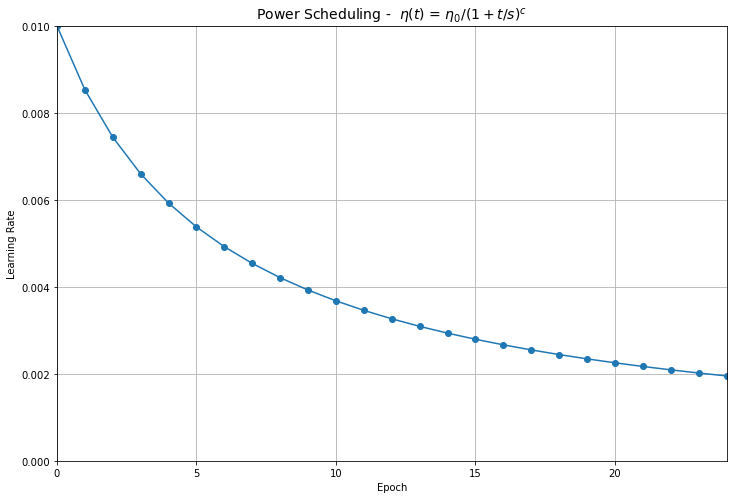

In [75]:
import matplotlib.pyplot as plt
learning_rate = 0.01
decay = 0.0001
batch_size= 32
n_Steps_per_epoch = len(X_train)/batch_size
epochs = np.arange(25)
lrs  = learning_rate / (1+decay * epochs * n_Steps_per_epoch)

plt.figure(figsize=(12, 8))
plt.plot(epochs, lrs, 'o-')
plt.axis([0, 24, 0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Power Scheduling -  $\eta (t)$ = $\eta_0  / (1 + t/s)^c$', fontsize=14)
plt.grid('on')


##### Exponential Scheduling - $\eta_0 0.1 ^{t/s}$
You define a configured function and insert it into the callbacks LearningRateScheduler

In [76]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.01, s= 20) #slashes the learning rate after 20 epochs


In [77]:
#Pass the LearningRateScheduler and input your function 
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, validation_data= (X_valid_scaled, y_valid), epochs= 25,
                   callbacks= [lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1514 - accuracy: 0.9486 - val_loss: 0.3031 - val_accuracy: 0.8918 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1509 - accuracy: 0.9488 - val_loss: 0.3026 - val_accuracy: 0.8928 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1507 - accuracy: 0.9487 - val_loss: 0.3025 - val_accuracy: 0.8926 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1506 - accuracy: 0.9489 - val_loss: 0.3023 - val_accuracy: 0.8924 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1505 - accuracy: 0.9489 - val_loss: 0.3023 - val_accuracy: 0.8928 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1504 - accuracy: 0.9489 - val_loss: 0.3022 - val_accuracy: 0.8926 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 7s

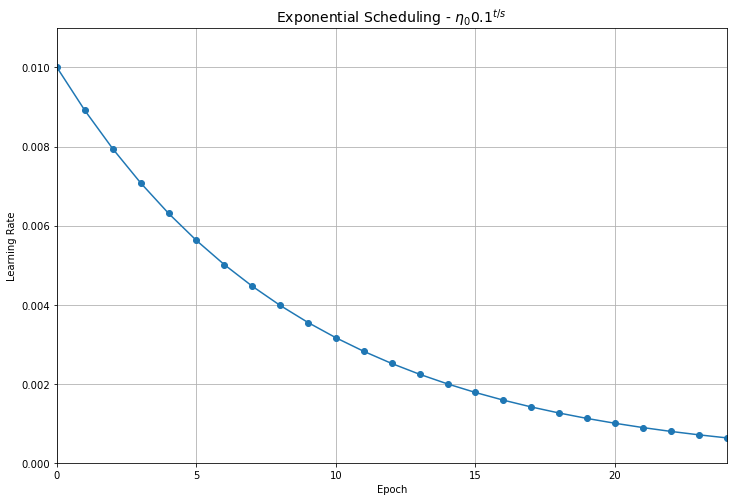

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(history.epoch, history.history['lr'], 'o-')
plt.axis([0, 24, 0, 0.011])

plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Exponential Scheduling - $\eta_0 0.1 ^{t/s}$', fontsize=14)
plt.grid('on')

You can even update the learning rate at each step rather each per epoch by writing your own Callback class. Where the learning rate drops per batch. you need to make sure that the optimizers initial learning rate is set appropriately. 
<i>Saving a model allows the optimizer and its learning rate to get saved so it your learning rate deponds on the number epochs, you will have a problem. You will have to set the fit() method's initial_epoch argument to the the appropriate value. 

In [79]:
class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
    
    def on_batch_begin(self, batch, logs= None):
        lr = keras.backend.get_value(self.model.optimizer.lr)
        keras.backend.set_value(self.model.optimizer.lr, lr * 0.1**(1/s))
        
    def on_epoch_end(self, epoch, logs= None):
        logs= logs or {}
        logs['lr'] = keras.backend.get_value(self.model.optimizer.lr)

#then build and compile a model and insert the class instance into the callbacks argument
# For example, say you want to build a scheduler that changes after 20 epochs (bacth_size= 32)
# s = 20 * len(X_train) //32

##### Peicewise Constant Scheduling - constant $\eta$ for 5 epochs

In [80]:
def peicewise_constant_fn(epoch):
    if epoch <5:
        return 0.01
    elif epoch <15:
        return 0.005
    else: 
        return 0.001

In [81]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) -1]
    return peicewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [82]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=25,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8645 - accuracy: 0.7535 - val_loss: 0.8604 - val_accuracy: 0.7476 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8024 - accuracy: 0.7687 - val_loss: 0.7375 - val_accuracy: 0.7866 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0302 - accuracy: 0.6916 - val_loss: 1.2561 - val_accuracy: 0.5610 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 1.2008 - accuracy: 0.5741 - val_loss: 1.0634 - val_accuracy: 0.5614 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 1.1407 - accuracy: 0.5538 - val_loss: 1.1067 - val_accuracy: 0.5534 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9605 - accuracy: 0.5797 - val_loss: 0.9378 - val_accuracy: 0.5790 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

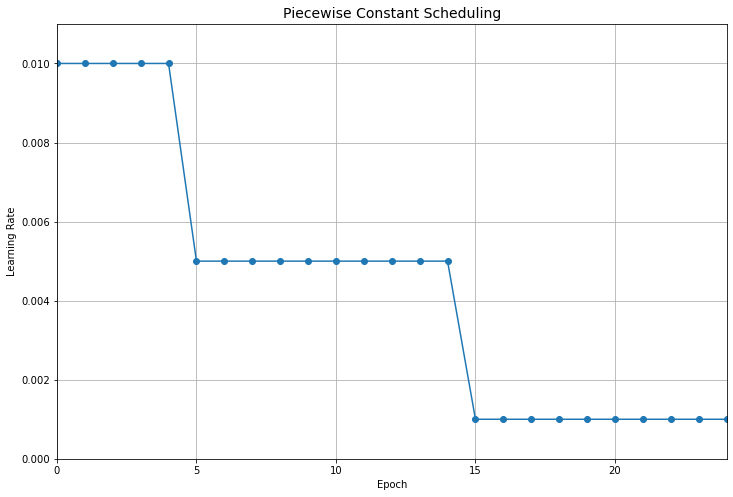

In [83]:
plt.figure(figsize= (12, 8))
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, 24, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

#####  Performance Schedulling 

In [84]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor= 0.5, patience= 5) #multply LR after 5 consecutive no improvements 

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


history = model.fit(X_train_scaled, y_train, epochs=25,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5965 - accuracy: 0.8062 - val_loss: 0.4787 - val_accuracy: 0.8502 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4940 - accuracy: 0.8403 - val_loss: 0.5971 - val_accuracy: 0.8334 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5162 - accuracy: 0.8409 - val_loss: 0.5664 - val_accuracy: 0.8494 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5574 - accuracy: 0.8408 - val_loss: 0.4607 - val_accuracy: 0.8522 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5385 - accuracy: 0.8465 - val_loss: 0.6403 - val_accuracy: 0.8310 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5198 - accuracy: 0.8505 - val_loss: 0.5543 - val_accuracy: 0.8614 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 7s

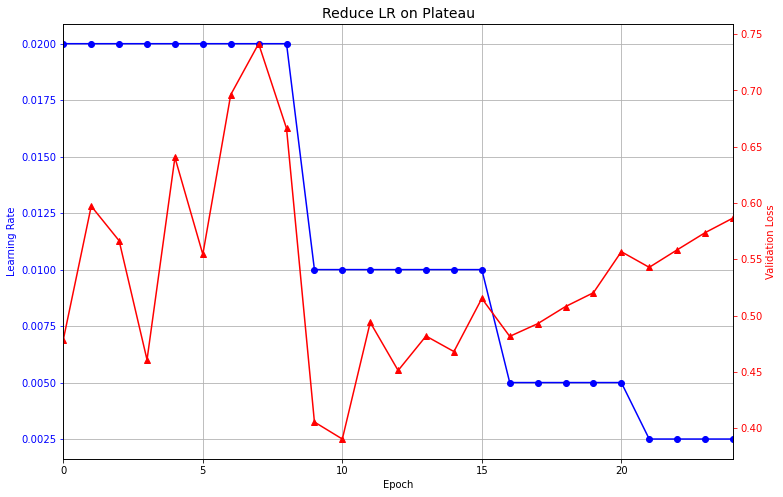

In [85]:
plt.figure(figsize= (12, 8))
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, 24)
plt.grid('on')

#plot second axis as validation loss
ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

# Fortunately, Tensorflow2's can allow easily implementation of all of the above rather than creating your own functions. 
<i> note Keras, does not have this, this is specific to Tensorflow.keras

In [86]:
s =20*len(X_train)//32

#Exponential Decay
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)

In [87]:
#Piecewise Constant Scheduling 

# lr_scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries=[5. n_steps_per_epoch, 15. * n_steps_per_epoch],
#     values=[0.01, 0.005, 0.001])

#### 1Cycle is simple as well but you need to create a Custom Callback
But first you need to plot the learning rate and to determine the maximum learning rate.

In [88]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor 
        self.rates = []
        self.losses = []
    
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
    
def find_learning_rate(model, X, y, epochs=1 , batch_size=32, min_rate= 10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate/min_rate) / iterations)
    init_lr = keras.backend.get_value(model.optimizer.lr)
    keras.backend.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    
    history = model.fit(X, y, epochs=epochs, batch_size= batch_size,
                       callbacks= [exp_lr])
    
    keras.backend.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses
    
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), max(losses)])
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')

In [89]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")])

model.compile(loss= "sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.3714


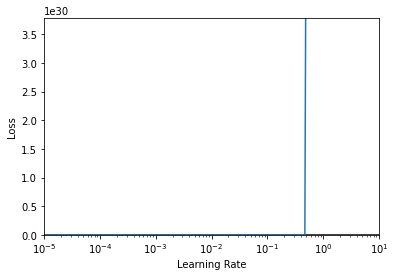

In [90]:
batch_size= 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                  batch_size=batch_size)
plot_lr_vs_loss(rates=rates, losses=losses)

##### Implement Cycle1

In [91]:
class OneCycleScheduler(keras.callbacks.Callback):
    
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        keras.backend.set_value(self.model.optimizer.lr, rate)

In [92]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])


Epoch 1/25
430/430 [==============================] - 4s 9ms/step - loss: 0.6630 - accuracy: 0.7697 - val_loss: 0.4892 - val_accuracy: 0.8356
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.4603 - accuracy: 0.8387 - val_loss: 0.4300 - val_accuracy: 0.8568
Epoch 3/25
430/430 [==============================] - 4s 9ms/step - loss: 0.4142 - accuracy: 0.8552 - val_loss: 0.4130 - val_accuracy: 0.8590
Epoch 4/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3848 - accuracy: 0.8641 - val_loss: 0.3891 - val_accuracy: 0.8640
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3640 - accuracy: 0.8720 - val_loss: 0.3727 - val_accuracy: 0.8666
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3460 - accuracy: 0.8773 - val_loss: 0.3745 - val_accuracy: 0.8716
Epoch 7/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3330 - accuracy: 0.8815 - val_loss: 0.3629 - val_accuracy: 0.8744
Epoch 

# Avoiding Overfitting Through Regularization
Deep Neural Networks have plenty of parameters ~ potentially millions ~ which gives it flexibility to fit even the most complex datasets. However, with great parameter numbers comes great over fitting so we need to act responsible. 
Batch Normalization acted as a great regularizer and as did Early Stopping callback but there other more commonly used techniques that we can take advantage off:

1. $\ell_1$ and $\ell_2$ regularization
Just like linear models where we used Lasso and Ridge regularization, this is simple the same albeit within a neural network. The $\ell_1$ regularization reduces features that are not important to 0 and returns a sparse model (with many weights equal to 0 or nonzero). 

The regularization loss is computed at each step and added to the total loss. You must __specify the regularization factor__ when you call the kernel_regularizer.  

2. Dropout
During training neurons within layers may start co-adapting which makes the networks more prone to overfitting. One way to alleviate this is to randomly drop some neurons during each training step - including the input neurons and except the output layer. This makes each neuron less reliant on their inputs and less likely to co-adpt to their neighbouring nuerons.

We set $p$ which is the __adaptive rate__, $p$ is a probability a neuron is dropped and temporarily ignored during each training step. The trained neuron can be thought of as an ensemble of smaller neural networks. 

Once training is complete, all the neurons would be expecting that $p$ neurons are inactive, so there are many more input neurons than expected during testing thus not performing well. To prevent this, we multiply each input connection weight by the __keep probability__ ($1 - p$) after training. Keras, divides the neuron inputs by keep probability - which not exactly the same but it still works. 

<i>There are rules of thumb for setting the value of $p$ depending on the network but typically it is set between 10%~50%. If you model is overfitting try increasing $p$ or you may want to consider just applying dropout to the upper layers.</i>

Dropout is active during training so you should not compare the training and validation losses. If a model has similiar training and validation loss, you should evaluate the actual training loss after training. 

To regularize the selu activation function, you should use __Alpha Dropout__ which preserves the mean and standard deviation of its input as normal dropout does not preserve self-normalization.

3. Monte-Carlo (MC) Dropout
Without dwelling into the maths, Dropout networks is mathematially equivalent to the Bayesian Inference in a specifc type of model - called Deep Gaussian process. The MC Dropout boosts the performance and the uncertainty of the dropout model without the need to retrain it again or switch of the dropout layers.

MC Dropout simply put, takes the average of $N$ predictions while keeping dropout activated. The larger the value of $N$ the more predictions we have and their uncertainty estimates. However, you should be mindful of the standard deviation of the estimates as this gives a better indication on the certainty of the model - a larger standard deviation of the class prediction indicates the uncertainty. Ultimately, there is a trade off between accuracy and latency.

Note, If you already are implementing batch normalization then you should not use MCDropout on all layers, you should only replace MCDropout to the Dropout layers. 

4. Max-Norm Regularization
The weights, $W$, for each neuron are constrained so that || $W$ ||$_2 \leq r$, where $r$ is the max-norm hyperparameter. This is a popular technique that does not add onto the loss term and alleviates unstable gradient problems. The computing occurs __after each training step__ where the $W$ is rescaled, if required (i.e. bigger than $r$). Weights are updated $W\leftarrow W r || W||_2$ per training step.

Reducing $r$ increases regularization and helps reduce overfitting.



Code examples on how to apply all of these techniques are below.


In [93]:
#Applying L1 regularization
layers = keras.layers.Dense(100, activation= 'elu',
                           kernel_initializer= 'he_normal',
                           kernel_regularizer= keras.regularizers.l1(0.1))

#Applying L2 regularization, by simplying changing the kernel_regularizer to keras.regularizers.l2(0.01)
#you can apply both l1 and l2 regularization by keras.regularizers.l1_l2(0.1, 0.01)

layers = keras.layers.Dense(100, activation= 'elu',
                           kernel_initializer= 'he_normal',
                           kernel_regularizer= keras.regularizers.l1_l2(0.1, 0.01))

In [94]:
#Applying Dropout

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate= 0.2),
    keras.layers.Dense(300, activation= 'elu', kernel_initializer= 'he_normal'),
    keras.layers.Dropout(rate= 0.2),
    keras.layers.Dense(100, activation= 'elu', kernel_initializer= 'he_normal'),
    keras.layers.Dropout(rate= 0.2),
    keras.layers.Dense(10, activation= 'softmax')
])

In [95]:
#Applying Alpha Dropout

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate= 0.2),
    keras.layers.Dense(300, activation= 'elu', kernel_initializer= 'he_normal'),
    keras.layers.AlphaDropout(rate= 0.2),
    keras.layers.Dense(100, activation= 'elu', kernel_initializer= 'he_normal'),
    keras.layers.AlphaDropout(rate= 0.2),
    keras.layers.Dense(10, activation= 'softmax')
])

In [96]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 300)               235500    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               30100     
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)               

In [97]:
#Create a Monte Carlo Dropout class that sets training=True when called

class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

    
#ditto with MCAlpha instead
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [98]:
#building a model that includes a MCDropout layer is easy all you have to do is train a model with dropout
#then convert an existing model to use MCDropout using the class created above

mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [99]:
mc_model.summary() #you can see that the Alpha Dropout layers have changed to MC Alpha 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)               

In [100]:
# you can now use the mc_model to make predictions, after you compile and set the weights
mc_model.compile(optimizer= 'sgd', metrics= ['accuracy'], loss = 'sparse_categorical_crossentropy')

#set the weights using the previously trained model (that used dropout)
mc_model.set_weights(model.get_weights())

In [101]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2) #make predictions

array([[0.1 , 0.17, 0.07, 0.06, 0.12, 0.08, 0.05, 0.15, 0.09, 0.11]],
      dtype=float32)

In [102]:
# Max Norm Regularization can be applied by setting kernel_constraint for all the hidden layers

keras.layers.Dense(100, activation= 'elu', kernel_initializer= 'he_normal',
                  kernel_constraint= keras.constraints.max_norm(1.)) #set max value to 1.

#the default is axis=0 for max_norm so applies max_norm to each neuron's weight vector. 
#for convolutional layers, you will have to set the axis argument differently, usually axis= [0, 1, 2]

___NOTE__ So far we have been retyping the neural networks and its parameters by retyping each layer individually - mostly to gain practice. But this can be cumbersome so maybe we can use a python function to apply the same set of parameters everytime a neural network layer is made. 

Luckily, we have functools.partial() function

In [103]:
from functools import partial

RegularizedDenseLayer= partial(keras.layers.Dense, activation= 'elu',
                                                  kernel_initializer= 'he_normal',
                                                  kernel_regularizer= keras.regularizers.l2(0.01))

#now every time you call the above instance, you do not need to rewrite all the parameters

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape= [28, 28]),
    RegularizedDenseLayer(300),
    RegularizedDenseLayer(100),
    RegularizedDenseLayer(10, activation= 'softmax', kernel_initializer= 'glorot_uniform')
])
